In [2]:
import os
from pathlib import Path
import math

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, add_pathways_to_deseq_df, show_pathways_in_ranked_genes
from dokdonia.utils import terminal_execute, readFromPickleFile, saveToPickleFile

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

## Load datasets

In [3]:
TC = pd.read_csv(data_dir / "processed" / "DokdoniaMED134_TC.tsv", sep="\t").set_index("index")
# TC.index.name = None
deseq2_counts = pd.read_csv(data_dir / "processed" / "DokdoniaMED134_DS2.tsv", sep="\t").set_index("index")
DELD = readFromPickleFile(results_dir / "deseq_results" / "DELD.pkl")

In [4]:
from dokdonia.utils import take_average_values, z_normalize


TC_avg = take_average_values(TC, method='median')
TC_avg_Z = z_normalize(take_average_values(TC, method='median'))

group3 = TC_avg_Z[TC_avg_Z[10] > TC_avg_Z[18]]

In [5]:
downgenes = group3[(group3[10] > group3[18]) & (group3[18] > group3[25]) & (group3[25] > group3[34])]
downgenes

Temperature,10,18,25,34
index,,,,
MED134_05809,1.182858,0.792660,-0.884801,-1.090717
MED134_05814,1.163565,0.787169,-0.726568,-1.224166
MED134_06129,1.195291,0.735331,-0.676417,-1.254204


NOTE: original downgenes identified with transcript / volume not transcript / cell

<AxesSubplot: xlabel='Temperature'>

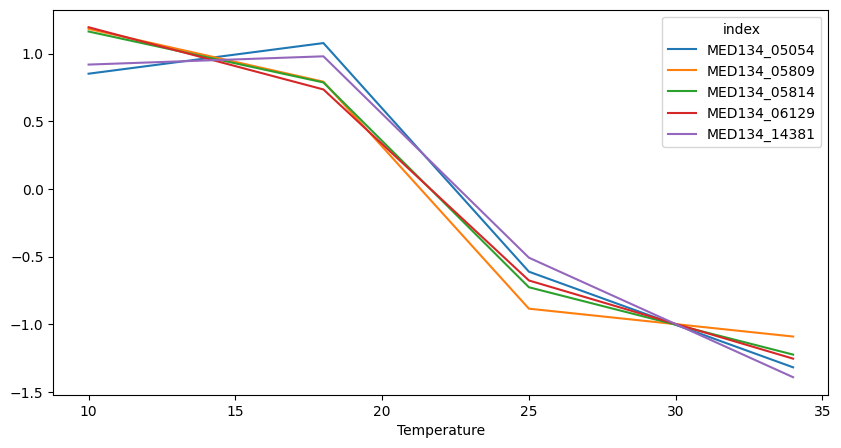

In [6]:
downgenes = [
    "MED134_05054",
    "MED134_05809",
    "MED134_05814",
    "MED134_06129",
    "MED134_14381",
]


TC_avg_Z.loc[downgenes,:].transpose().plot(legend=True, figsize=(10, 5))

In [7]:
light_marker_genes = [
    ("MED134_07119", "proteorhodopsin"),
    ("MED134_14266", "deoxyribodipyrimidine photo-lyase class I"),
    ("MED134_10201", "cryptochrome of the DASH family"),
    ("MED134_13071", "phytoene synthase"),
    ("MED134_13076", "phytoene dehydrogenase"),
    ("MED134_13081", "transcription regulator, MerR family"),
    ("MED134_10206", "a deoxyribodipyrimidine photolyase-related protein"),
    ("MED134_10211", "DNA photolyase/cryptochrome"),
    ("MED134_07089", "blue light sensor using FAD"),
]

dark_marker_genes = [
    ("MED134_06219", "two-component system sensor histidine kinase"),
]

plot_marker_genes = {
    "C0": [
        ("MED134_05219","TonB dependent/ligand-gated channel"),
        ("MED134_14141","isocitrate dehydrogenase"),
        ("MED134_04959","preprotein translocase, YajC subunit"),
        ("MED134_09101", "superoxide dismutase"),
        ("MED134_12981", "DNA gyrase subunit B"),
        ("MED134_04754", "DNA topoisomerase IV, subunit A"),
        ("MED134_06494","DNA polymerase III subunit gamma/tau"),
        ("MED134_01190","gliding motility protein GldK"),
        ("MED134_12046","gliding motility protein GldJ"),
    ],
    "C1": [
        ("MED134_02950", "30S ribosomal protein S1"),
        ("MED134_02405", "50S ribosomal protein L1"),
        ("MED134_12576", "citrate synthase"),
        ("MED134_13701", "succinyl-CoA synthetase, beta subunit"),
        ("MED134_07711", "2-oxoglutarate dehydrogenase E1 component"),
        ("MED134_14156", "prolyl-tRNA synthetase"),
        ("MED134_11636", "alanyl-tRNA synthetase"),
        ("MED134_05054", "DEAD/DEAH box helicase"),
        ("MED134_14341", "DEAD/DEAH box helicase"),
        ("MED134_14381", "DEAD/DEAH box helicase"),
        ("MED134_10855", "cold shock domain protein CspD"),
        ("MED134_08066", "cold shock domain protein CspD"),
        ("MED134_05784", "cold shock domain protein CspD"),
    
    ],
    "C2": [
        ("MED134_04199", "DNA polymerase III, beta subunit"),
        ("MED134_08006", "biotin synthase"),
        ("MED134_01135", "TCP-1/cpn60 chaperonin protein family"),
        ("MED134_02620", "universal stress protein UspA"),
        ("MED134_02690", "universal stress protein UspA"),
        ("MED134_05259", "RNA polymerase sigma factor, sigma-70 family"),
        ("MED134_05579", "malate dehydrogenase (quinone)"),
        ("MED134_01780", "isocitrate lyase"),
        ("MED134_06589", "serine hydroxymethyltransferase"),
    ],
    "C3": [
        ("MED134_11471", "periplasmic protein TonB"),
        ("MED134_01520", "acetyl-CoA carboxylase carboxyl transferase subunit alpha"),
        ("MED134_03169", "Na+/H+ antiporter NhaC"),
        ("MED134_03030", "zinc carboxypeptidase"),
        ("MED134_13906", "metal-dependent amidohydrolase"),
        ("MED134_05959", "glycosyl transferase group 1"),
    ],
}

## Plot Deseq2 and TC values for some example genes

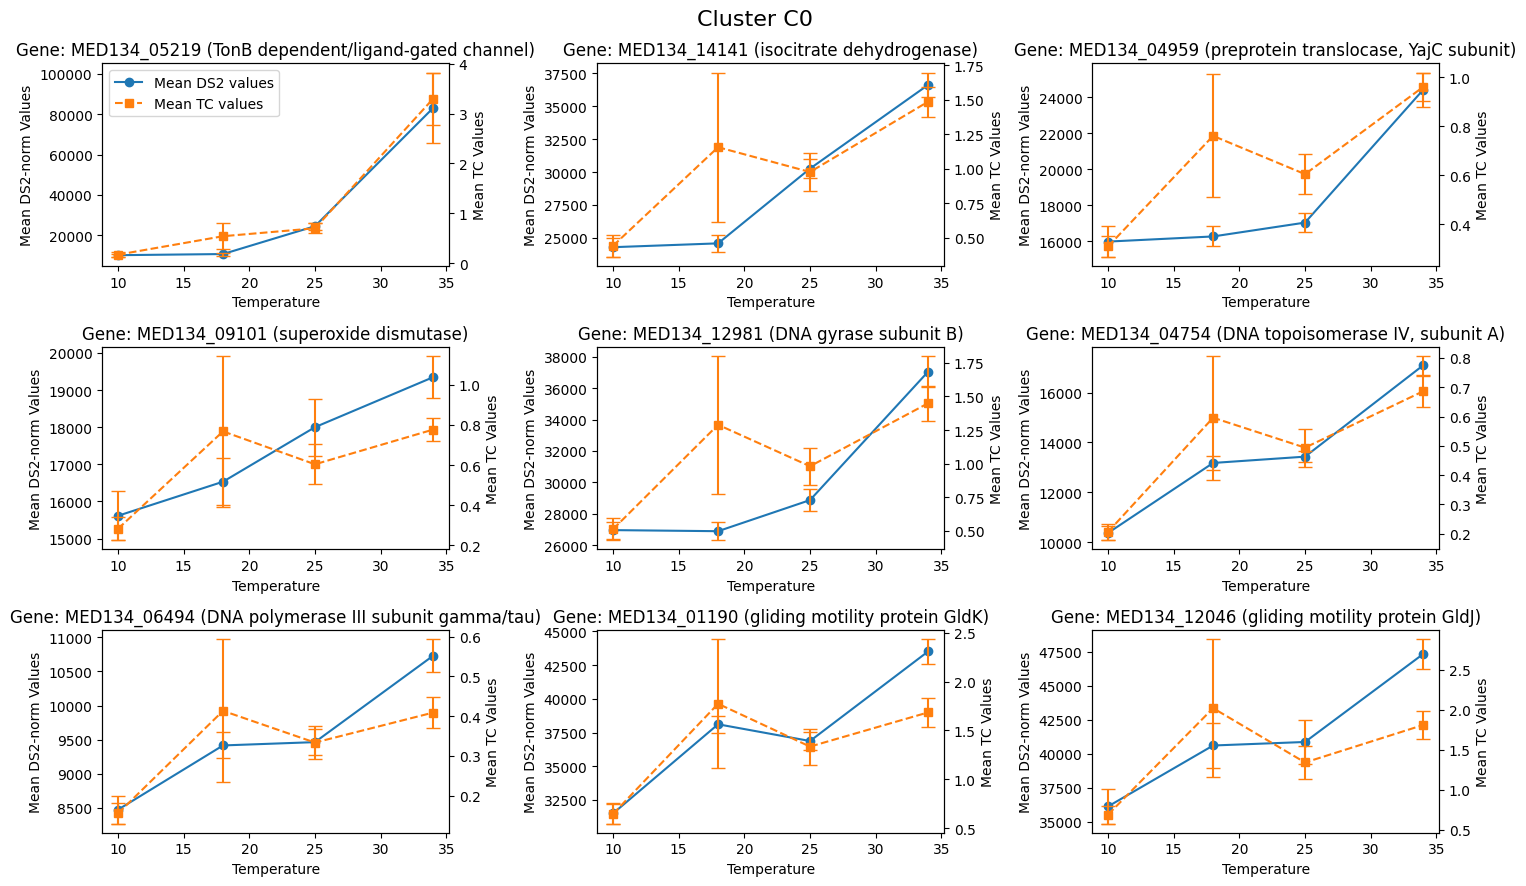

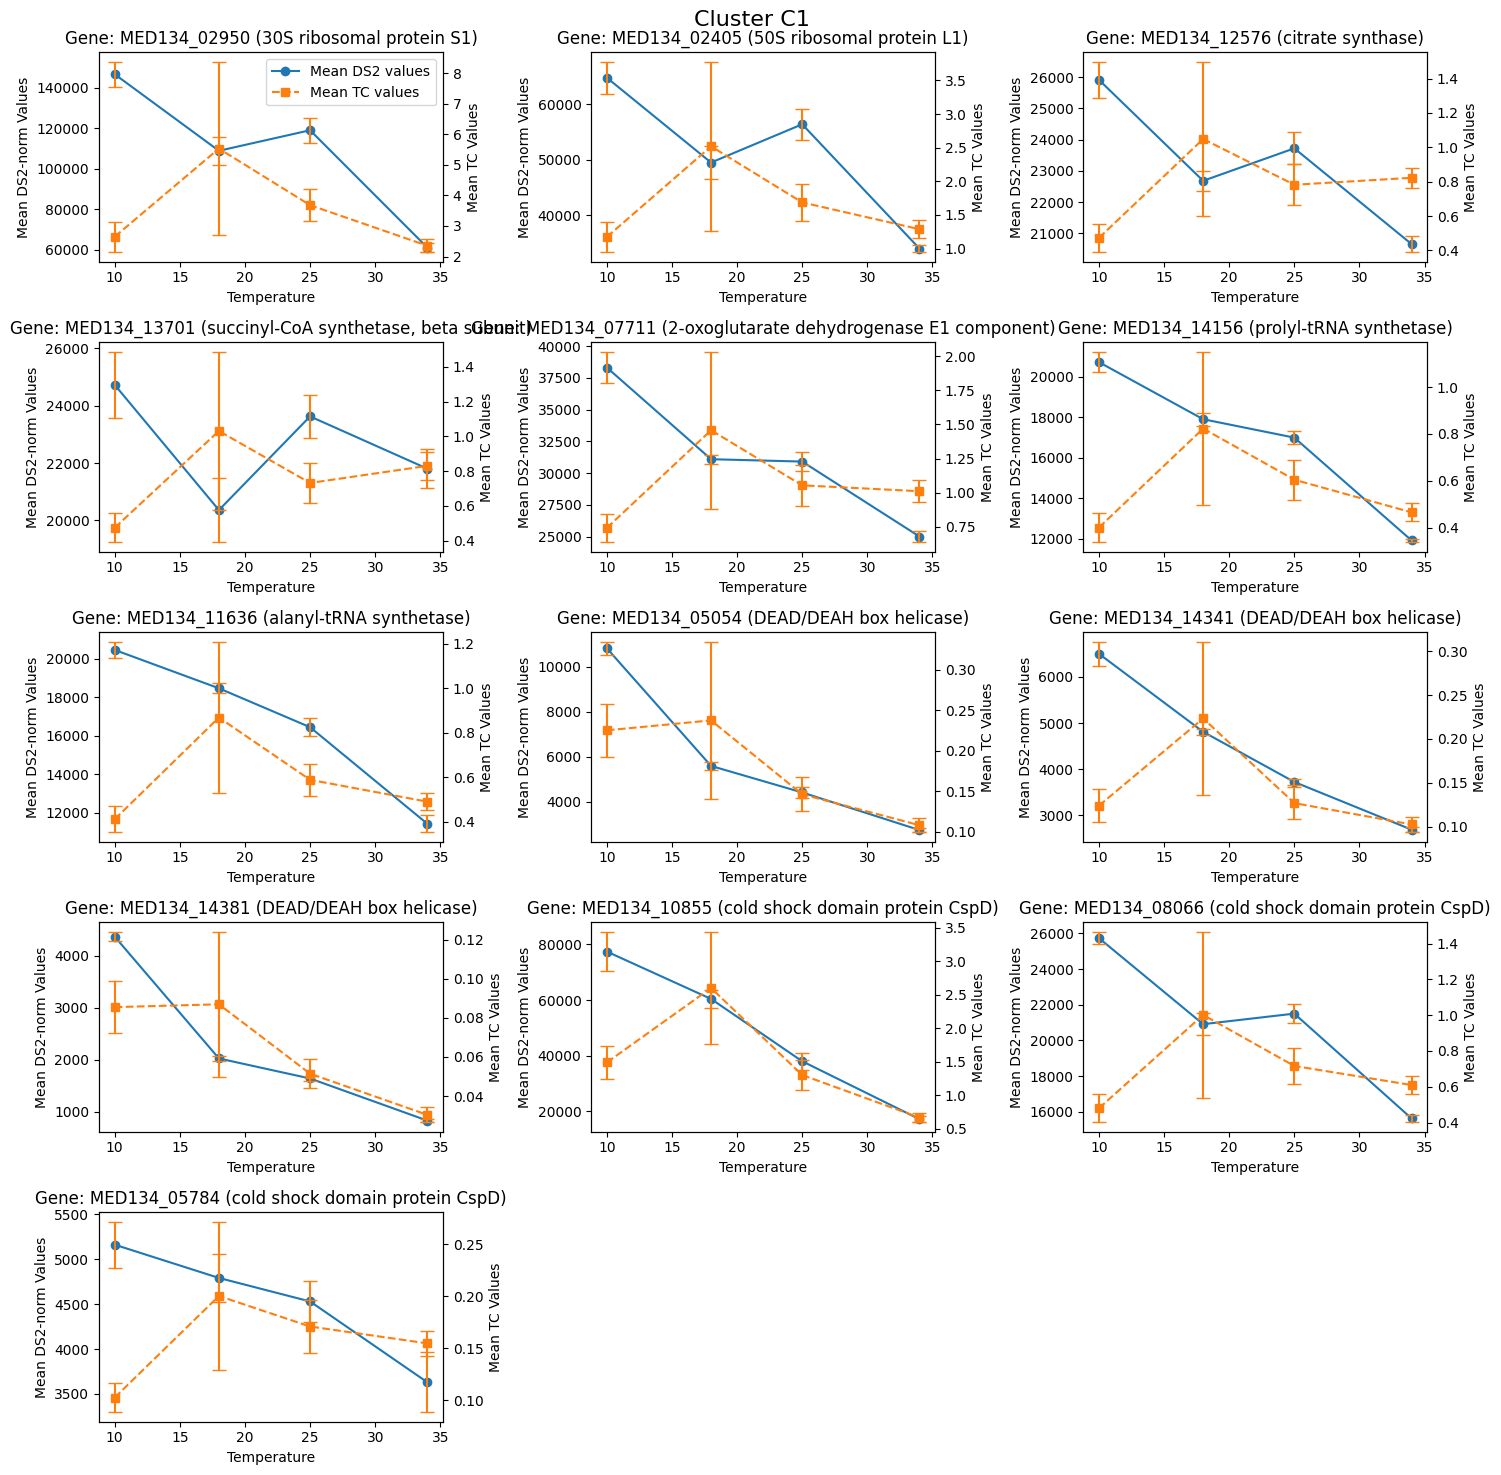

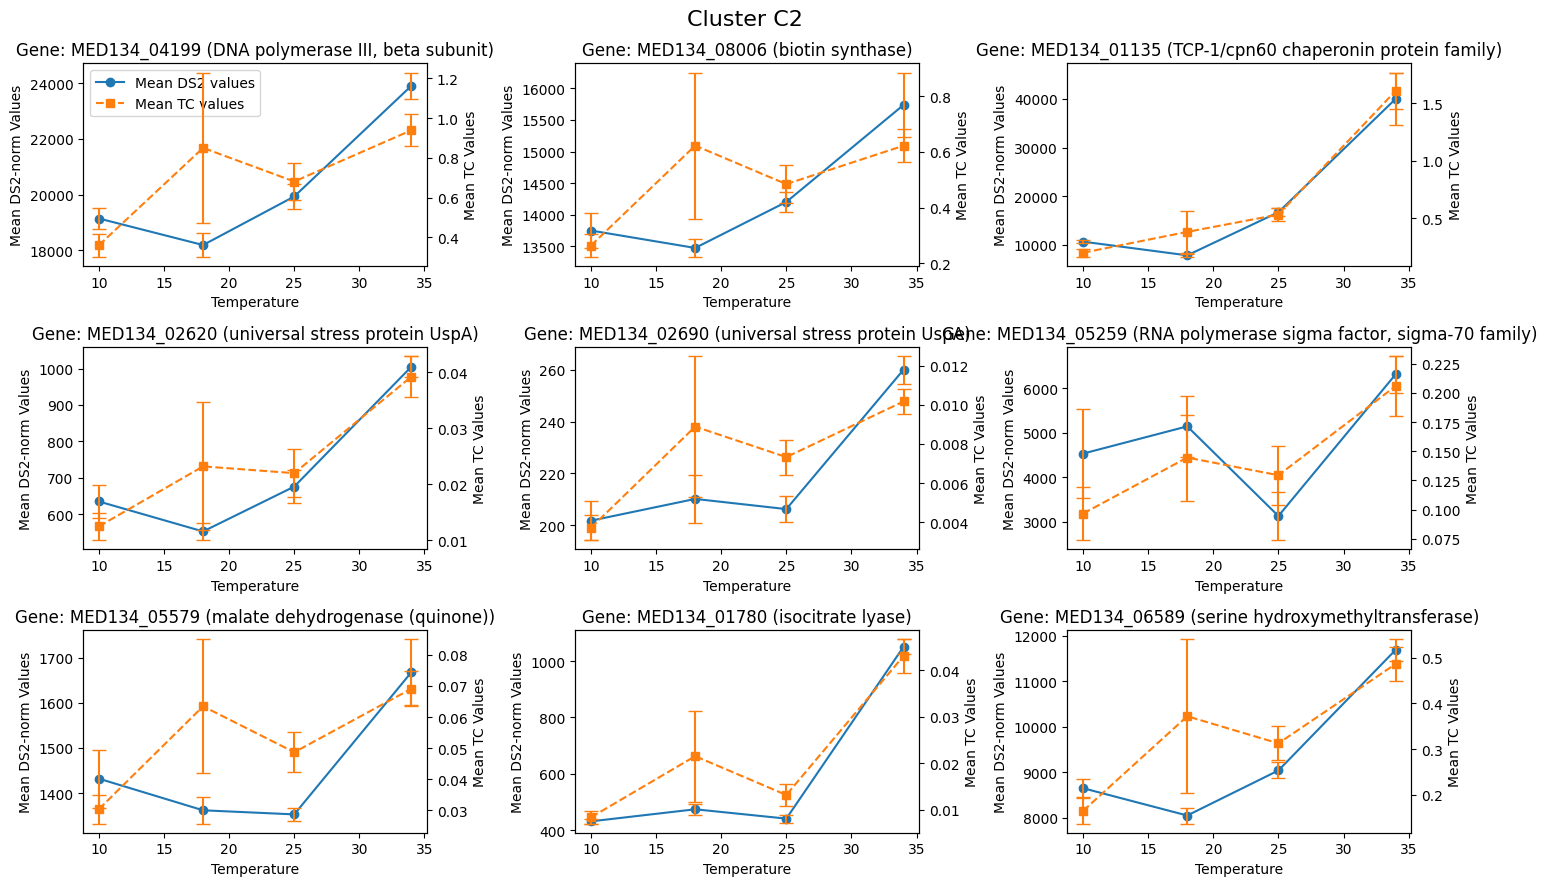

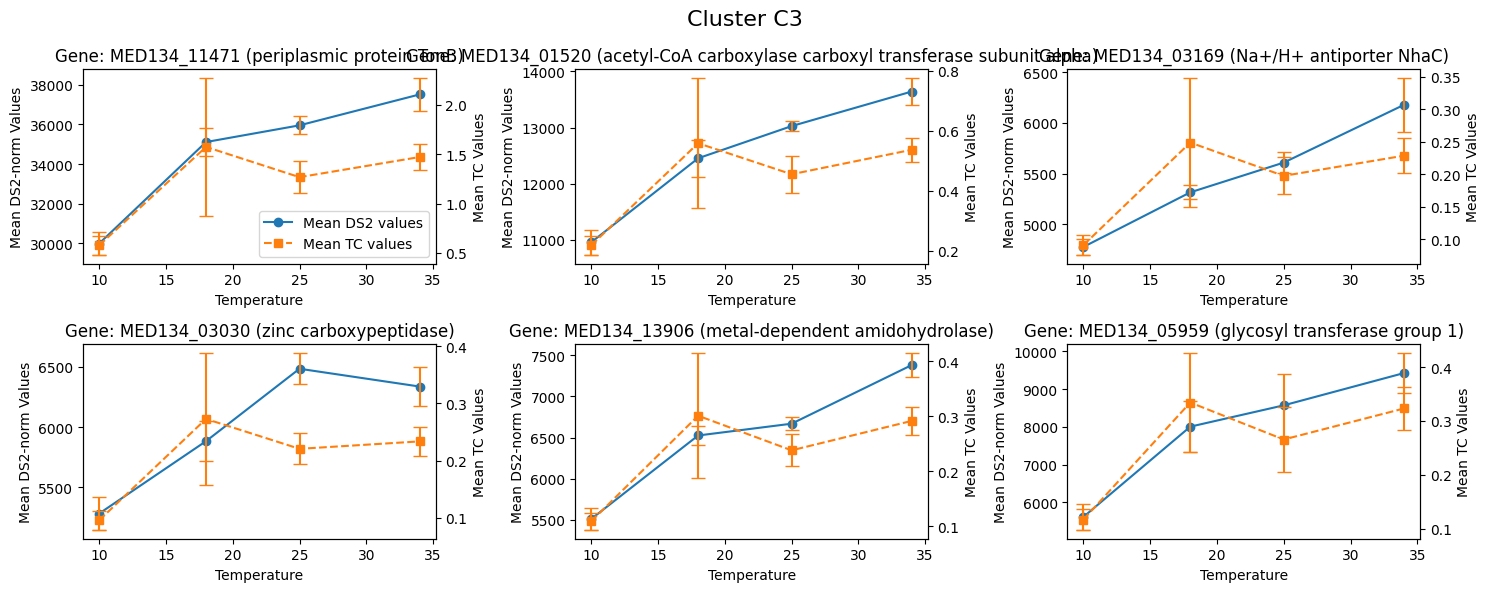

In [8]:
def plot_gene_expression(ax, gene_id, gene_name, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC, show_legend=False):
    l1 = ax.plot(mean_values['Temperature'], mean_values['Value'], marker='o', linestyle='-', label='Mean DS2 values')
    ax.errorbar(mean_values['Temperature'], mean_values['Value'], yerr=standard_error_values['Value'], linestyle='', capsize=5, label='SDE DS2 values')
    ax2 = ax.twinx()
    l2 = ax2.plot(mean_values_TC['Temperature'], mean_values_TC['Value'], marker='s', linestyle='--', color='C1', label='Mean TC values')
    ax2.errorbar(mean_values_TC['Temperature'], mean_values_TC['Value'], yerr=standard_error_values_TC['Value'], linestyle='', capsize=5, color='C1', label='SDE TC values')

    ax.set_xlabel('Temperature')
    ax.set_ylabel('Mean DS2-norm Values')
    ax2.set_ylabel('Mean TC Values')
    ax.set_title(f'Gene: {gene_id} ({gene_name})')
    if show_legend:
        legend_handles = l1 + l2
        legend_labels = [h.get_label() for h in legend_handles]
        ax.legend(legend_handles, legend_labels)

# Code for preprocessing the primary and secondary datasets
# Replace "TC" with the name of your second dataset
marker_genes = plot_marker_genes
target_genes = [gene[0] for cluster in marker_genes.values() for gene in cluster]

# Preprocess the primary dataset (deseq2_counts_noDE)
df_long = deseq2_counts.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

# Calculate mean and standard error values for the primary dataset (deseq2_counts_noDE)
grouped = df_long.groupby(['index', 'Temperature'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()

# Preprocess the secondary dataset (TC)
TC_long = TC.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
TC_long['Temperature'] = TC_long['Column'].str.extract('_(\d+)_')
TC_long['Temperature'] = pd.to_numeric(TC_long['Temperature'])

# Calculate mean and standard error values for the secondary dataset (TC)
grouped_TC = TC_long.groupby(['index', 'Temperature'])['Value']
mean_values_TC = grouped_TC.median().reset_index()
standard_error_values_TC = grouped_TC.sem().reset_index()

for cluster, genes in marker_genes.items():
    # Plotting
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    fig.suptitle(f'Cluster {cluster}', fontsize=16)
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
        mean_values_gene = mean_values[mean_values['index'] == gene_id]
        standard_error_values_gene = standard_error_values[standard_error_values['index'] == gene_id]
        mean_values_gene_TC = mean_values_TC[mean_values_TC['index'] == gene_id]
        standard_error_values_gene_TC = standard_error_values_TC[standard_error_values_TC['index'] == gene_id]
        show_legend = (idx == 0)
        plot_gene_expression(axs[idx], gene_id, gene_name, mean_values_gene, standard_error_values_gene, mean_values_gene_TC, standard_error_values_gene_TC, show_legend)

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.savefig(f'paper_figures/cluster_{cluster}_gene_expression_temperature.png')
    plt.show()

## Some genes to remove from Plot marker genes

In [9]:
genes_to_remove = {
    "C0": [
        "MED134_04959",
    ],
    "C1": [
        "MED134_13701",
    ],
    "C2": [
    ],
    "C3": [
        "MED134_03169",
    ],
}

## Plot all Light / Dark DE genes

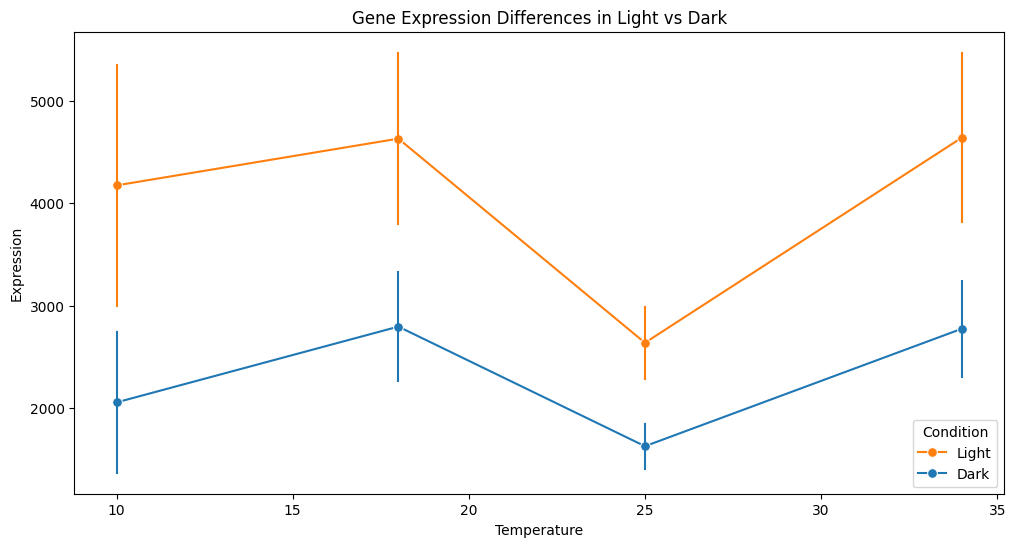

In [10]:
def process_temperature_data(temp, gene_set, deseq2_counts):
    columns_of_interest_light = [col for col in deseq2_counts.columns if f"L_{temp}_" in col]
    columns_of_interest_dark = [col for col in deseq2_counts.columns if f"D_{temp}_" in col]

    temp_data_light = deseq2_counts.loc[gene_set, columns_of_interest_light]
    temp_data_dark = deseq2_counts.loc[gene_set, columns_of_interest_dark]

    temp_data_light = temp_data_light.reset_index().melt(id_vars='gene_id', var_name='Sample', value_name='Expression')
    temp_data_light['Temperature'] = temp
    temp_data_light['Condition'] = 'Light'

    temp_data_dark = temp_data_dark.reset_index().melt(id_vars='gene_id', var_name='Sample', value_name='Expression')
    temp_data_dark['Temperature'] = temp
    temp_data_dark['Condition'] = 'Dark'

    temp_data = pd.concat([temp_data_light, temp_data_dark], axis=0)
    temp_data.rename(columns={'gene_id': 'Gene'}, inplace=True)

    return temp_data


temperatures = list(map(str, [10, 18, 25, 34]))

data = pd.concat(
    [
        process_temperature_data(temp, DELD[temp]['L>D'].index, deseq2_counts)
        for temp in temperatures
        if len(DELD[temp]['L>D']) > 0
    ],
    axis=0,
    ignore_index=True
)

data['Temperature'] = pd.to_numeric(data['Temperature'], errors='coerce')

if not data.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Temperature', y='Expression', marker='o', markersize=7, hue='Condition', data=data, errorbar='se', err_style='bars', palette=['C1', 'C0'])

    plt.xlabel('Temperature')
    plt.ylabel('Expression')
    plt.title('Gene Expression Differences in Light vs Dark')
    plt.legend(title='Condition', loc='lower right', labels=['Light', 'Dark'])

    plt.show()
else:
    print("No data to plot.")


## Plot individual plots for light/dark DE genes

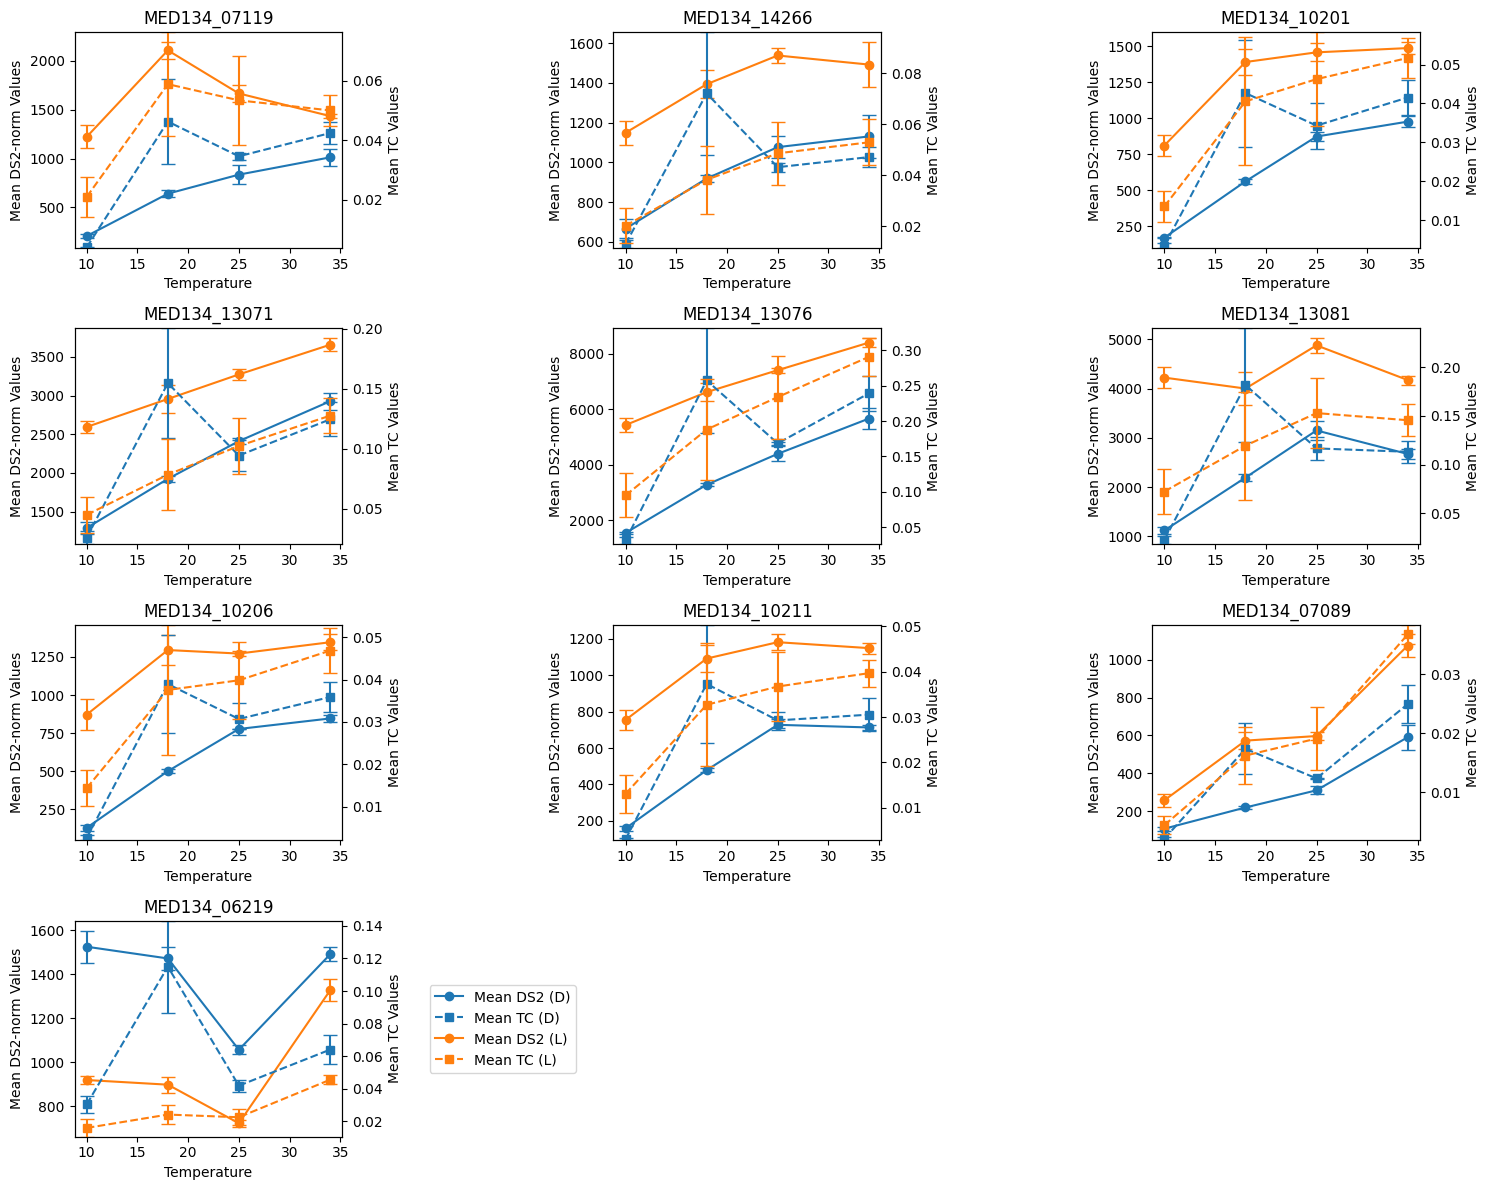

In [11]:
genes = light_marker_genes + dark_marker_genes
target_genes = [gene[0] for gene in genes]


# Preprocess the new dataset (TC)
df_long = deseq2_counts.reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])
df_long['Condition'] = df_long['Column'].str.extract('([LD])_')

# Calculate mean and standard error values for the new dataset (TC)
grouped = df_long.groupby(['index', 'Temperature', 'Condition'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()

# Preprocess the new dataset (TC)
TC_long = TC.loc[target_genes, :].reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
TC_long['Temperature'] = TC_long['Column'].str.extract('_(\d+)_')
TC_long['Temperature'] = pd.to_numeric(TC_long['Temperature'])
TC_long['Condition'] = TC_long['Column'].str.extract('([LD])_')

# Calculate mean and standard error values for the new dataset (TC)
grouped_TC = TC_long.groupby(['index', 'Temperature', 'Condition'])['Value']
mean_values_TC = grouped_TC.mean().reset_index()
standard_error_values_TC = grouped_TC.sem().reset_index()


def plot_gene_expression_light_dark(ax, gene_id, gene_name, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC, show_legend=False):
    conditions = ['D', 'L']
    
    # Create secondary y-axis for TC data
    ax2 = ax.twinx()

    lines = []
    labels = []

    for idx, condition in enumerate(conditions):
        mean_values_condition = mean_values[(mean_values['Condition'] == condition) & (mean_values['index'] == gene_id)]
        standard_error_values_condition = standard_error_values[(standard_error_values['Condition'] == condition) & (standard_error_values['index'] == gene_id)]
        
        line1, = ax.plot(
            mean_values_condition['Temperature'], 
            mean_values_condition['Value'],
            marker='o', linestyle='-',
            label=f'Mean DS2 ({condition})',
            color=f'C{idx}'
            )
        ax.errorbar(
            mean_values_condition['Temperature'], 
            mean_values_condition['Value'], 
            yerr=standard_error_values_condition['Value'], 
            linestyle='', capsize=5, 
            color=f'C{idx}'
            )

        mean_values_condition_TC = mean_values_TC[(mean_values_TC['Condition'] == condition) & (mean_values_TC['index'] == gene_id)]
        standard_error_values_condition_TC = standard_error_values_TC[(standard_error_values_TC['Condition'] == condition) & (standard_error_values_TC['index'] == gene_id)]

        line2, = ax2.plot(
            mean_values_condition_TC['Temperature'], 
            mean_values_condition_TC['Value'],
            marker='s', linestyle='--',
            label=f'Mean TC ({condition})',
            color=f'C{idx}'
            )
        ax2.errorbar(
            mean_values_condition_TC['Temperature'], 
            mean_values_condition_TC['Value'], 
            yerr=standard_error_values_condition_TC['Value'], 
            linestyle='', capsize=5, 
            color=f'C{idx}'
            )

        lines.append(line1)
        lines.append(line2)
        labels.append(line1.get_label())
        labels.append(line2.get_label())

    ax.set_xlabel('Temperature')
    ax.set_ylabel('Mean DS2-norm Values')
    ax2.set_ylabel('Mean TC Values')
    ax.set_title(f'{gene_id}')  # ({gene_name})')

    if show_legend:
        ax.legend(lines, labels, loc='center left', bbox_to_anchor=(1.3, 0.5))
        
    # Automatically adjust right y-axis limits and ticks
    ax2.autoscale(axis='y', tight=True)


def plot_genes(genes, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC):
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
        show_legend = (idx == len(genes) - 1)
        plot_gene_expression_light_dark(
            axs[idx], gene_id, gene_name,
            mean_values[mean_values['index'] == gene_id],
            standard_error_values[standard_error_values['index'] == gene_id],
            mean_values_TC[mean_values_TC['index'] == gene_id],
            standard_error_values_TC[standard_error_values_TC['index'] == gene_id],
            show_legend
            )

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.savefig('paper_figures/gene_expression_light_dark_DS2_TC.eps', format='eps', dpi=1000)
    plt.savefig('paper_figures/gene_expression_light_dark_DS2_TC.png')
    plt.show()

# Call the updated plot_genes function with the new dataset (TC)
plot_genes(genes, mean_values, standard_error_values, mean_values_TC, standard_error_values_TC)

## Same but without overlapping TC

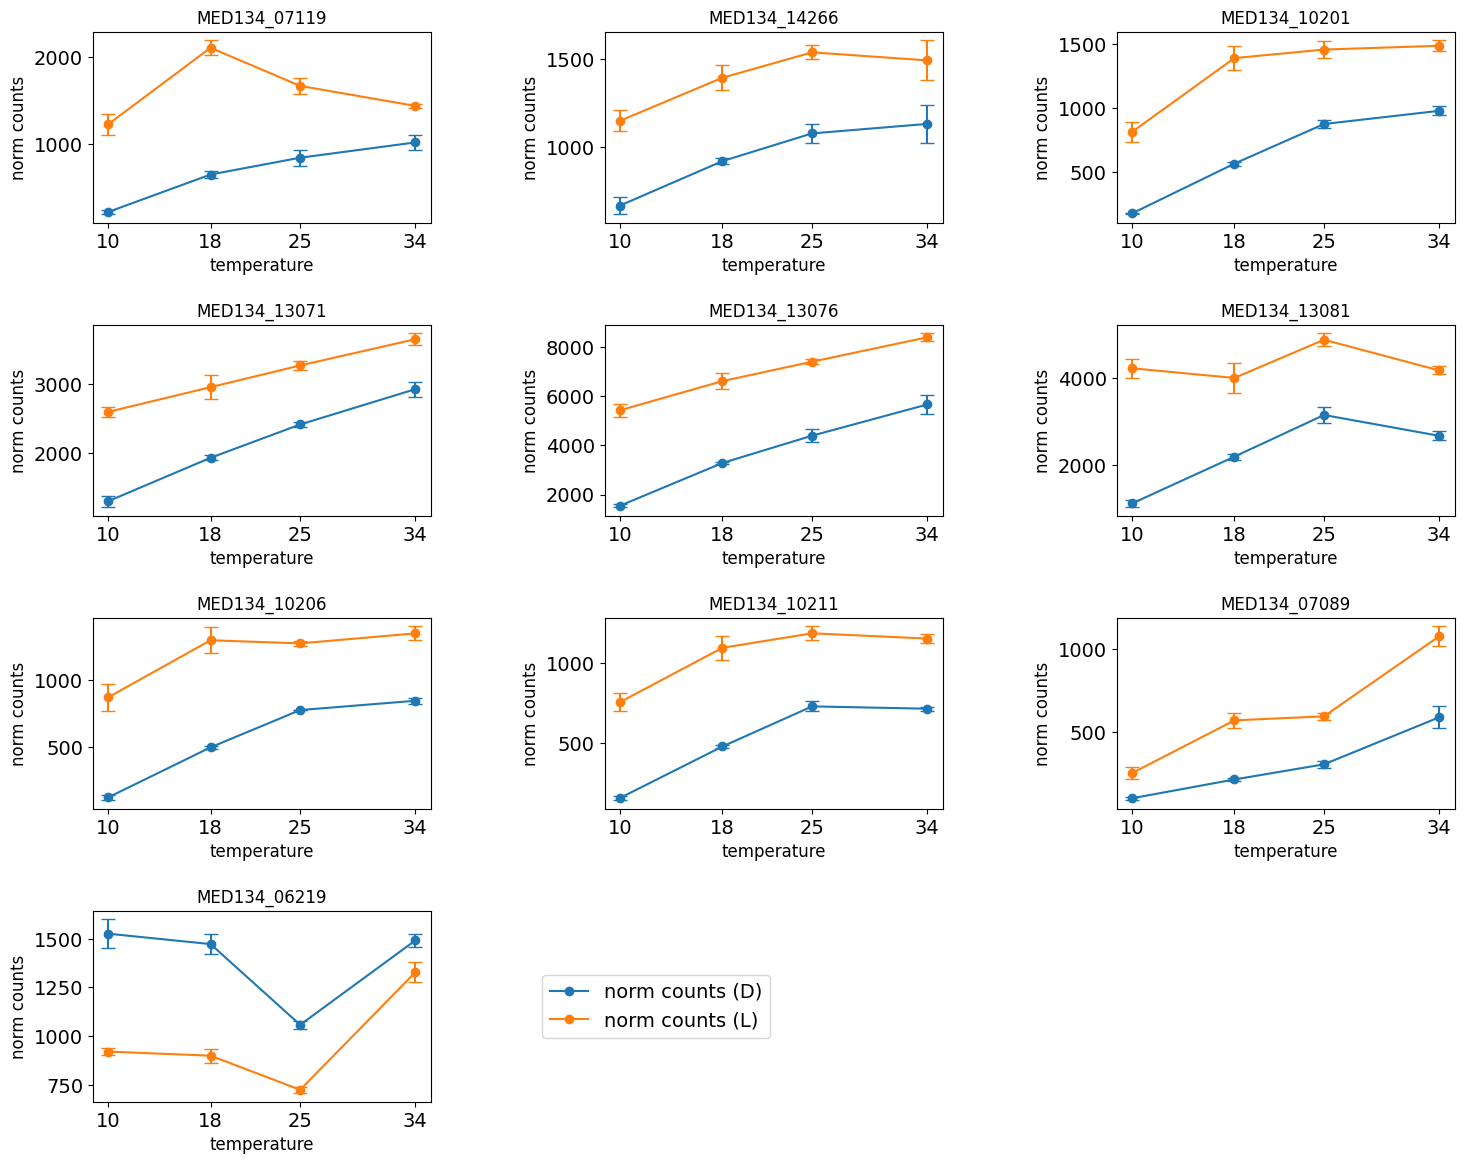

In [20]:
genes = light_marker_genes + dark_marker_genes
target_genes = [gene[0] for gene in genes]


# Preprocess the new dataset (TC)
df_long = deseq2_counts.reset_index().melt(id_vars='index', var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])
df_long['Condition'] = df_long['Column'].str.extract('([LD])_')

# Calculate mean and standard error values for the new dataset (TC)
grouped = df_long.groupby(['index', 'Temperature', 'Condition'])['Value']
mean_values = grouped.mean().reset_index()
standard_error_values = grouped.sem().reset_index()


def plot_gene_expression_light_dark(ax, gene_id, mean_values, standard_error_values, show_legend=False):
    conditions = ['D', 'L']
    lines = []
    labels = []

    for idx, condition in enumerate(conditions):
        mean_values_condition = mean_values[(mean_values['Condition'] == condition) & (mean_values['index'] == gene_id)]
        standard_error_values_condition = standard_error_values[(standard_error_values['Condition'] == condition) & (standard_error_values['index'] == gene_id)]
        
        line1, = ax.plot(
            mean_values_condition['Temperature'], 
            mean_values_condition['Value'],
            marker='o', linestyle='-',
            label=f'norm counts ({condition})',
            color=f'C{idx}'
            )
        ax.errorbar(
            mean_values_condition['Temperature'], 
            mean_values_condition['Value'], 
            yerr=standard_error_values_condition['Value'], 
            linestyle='', capsize=5, 
            color=f'C{idx}'
            )
        lines.append(line1)
        labels.append(line1.get_label())

    ax.set_xlabel('temperature', fontsize=12)  # increase fontsize
    ax.set_ylabel('norm counts', fontsize=12)  # increase fontsize
    ax.set_title(f'{gene_id}', fontsize=12)  # increase fontsize
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xticks([10, 18, 25, 34]) 

    if show_legend:
        ax.legend(lines, labels, loc='center left', bbox_to_anchor=(1.3, 0.5), fontsize=14)  # increase fontsize


def plot_genes(genes, mean_values, standard_error_values):
    nrows = math.ceil(len(genes) / 3)
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axs = axs.flatten()

    for idx, (gene_id, gene_name) in enumerate(genes):
        show_legend = (idx == len(genes) - 1)
        plot_gene_expression_light_dark(
            axs[idx], gene_id,
            mean_values[mean_values['index'] == gene_id],
            standard_error_values[standard_error_values['index'] == gene_id],
            show_legend
            )

    for idx in range(len(genes), nrows * ncols):
        fig.delaxes(axs[idx])

    plt.tight_layout(pad=2, w_pad=-12)
    plt.savefig('paper_figures/gene_expression_light_dark.eps', format='eps', dpi=1000)
    plt.savefig('paper_figures/gene_expression_light_dark.png')
    plt.show()


# Call the updated plot_genes function with the new dataset (TC)
plot_genes(genes, mean_values, standard_error_values)

Figure X: Gene expression (DeSeq2-normalized counts) of key genes in the light (orange) and dark (blue) conditions across various temperature treatments. All genes were overexpressed in the light across all temperatures (Wald test, alpha=0.01), with the exception of MED134_06219 which was overexpressed in the dark across temperatures. Lines correspond to mean values across all samples at the same tempeature, and error bars to the standard error of the mean. Genes depicted include: MED134_07119 (proteorhodopsin), MED134_14266 (deoxyribodipyrimidine photo-lyase class I), MED134_10201 (cryptochrome of the DASH family), MED134_13071 (phytoene synthase), MED134_13076 (phytoene dehydrogenase), MED134_13081 (transcription regulator, MerR family), MED134_10206 (a deoxyribodipyrimidine photolyase-related protein), MED134_10211 (DNA photolyase/cryptochrome), and MED134_07089 (blue light sensor using FAD).

## Plot DeSeq2 clusters

In [13]:
plot_cluster_data_DS2Z = readFromPickleFile(results_dir / "figures" / "figure_data" / "plot_cluster_data_DS2Z.pkl")
clusters_DS2Z = readFromPickleFile(results_dir / "figures" / "figure_data" / "clusters_DS2Z.pkl")

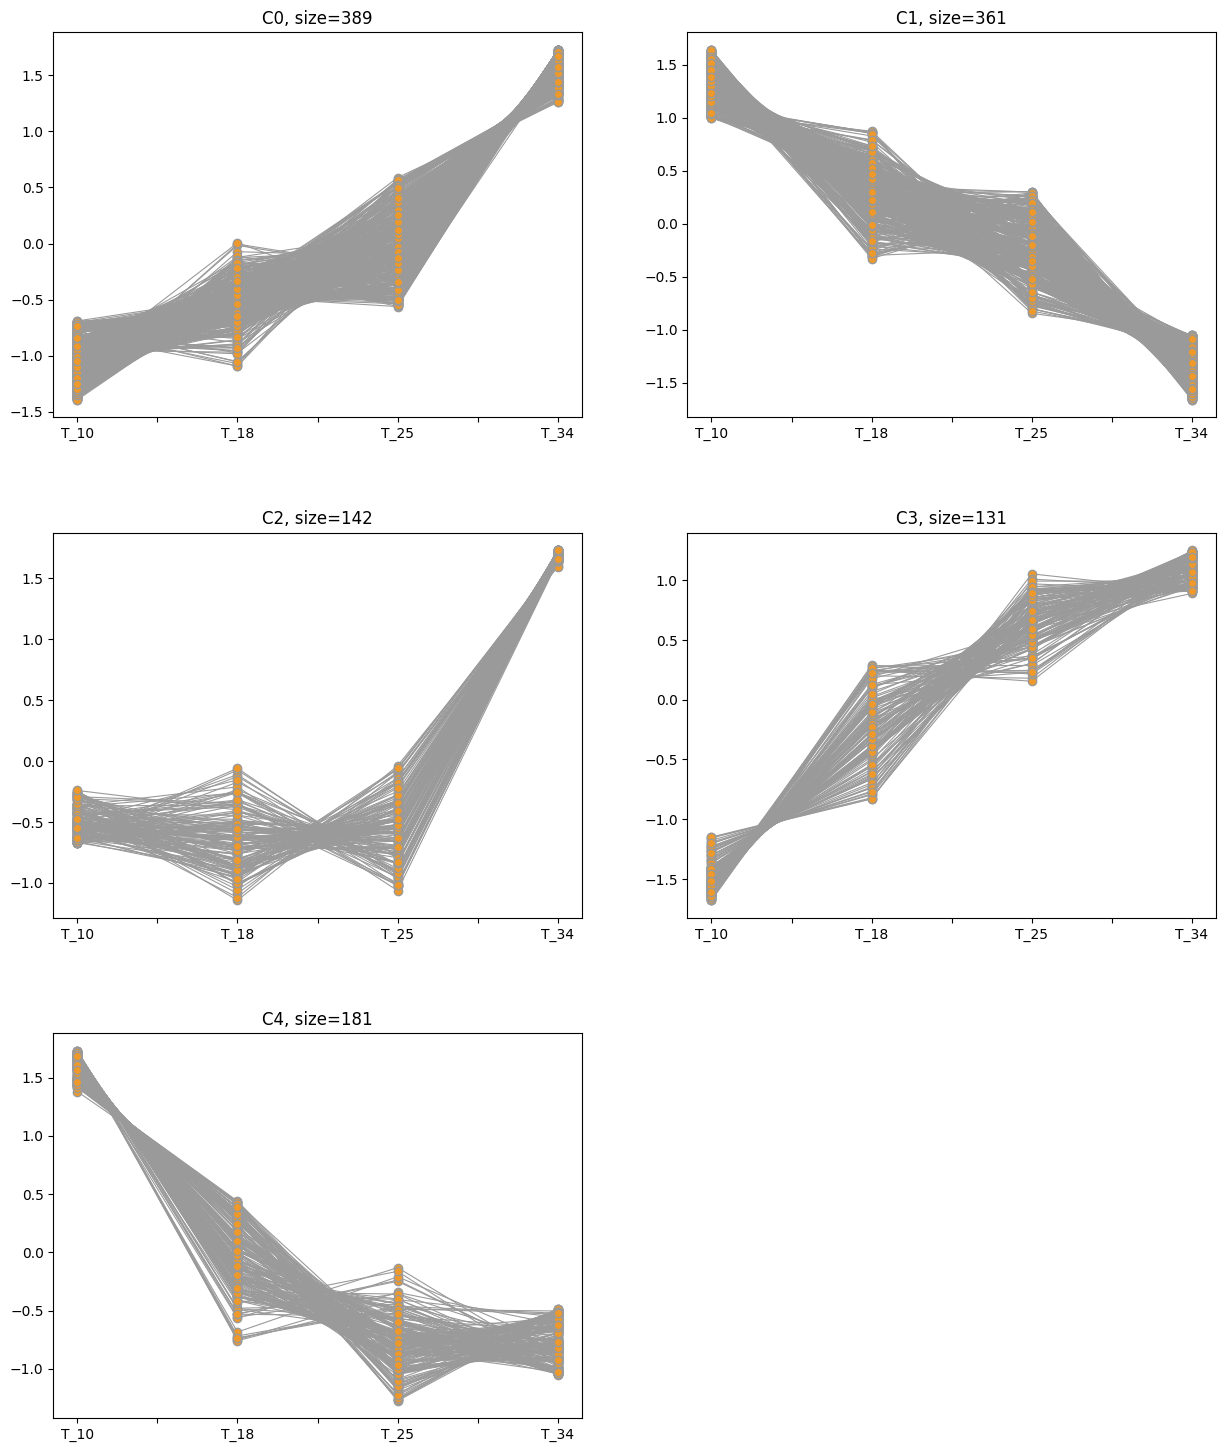

In [14]:
VI.plotClusters(
    plot_cluster_data_DS2Z, clusters_DS2Z,
    outfile="paper_figures/cluster_plot_DS2Z.eps",
    )

## Plot TC clusters

In [15]:
plot_cluster_data_TCZ = readFromPickleFile(results_dir / "figures" / "figure_data" / "plot_cluster_data_TCZ.pkl")
clusters_TCZ = readFromPickleFile(results_dir / "figures" / "figure_data" / "clusters_TCZ.pkl")

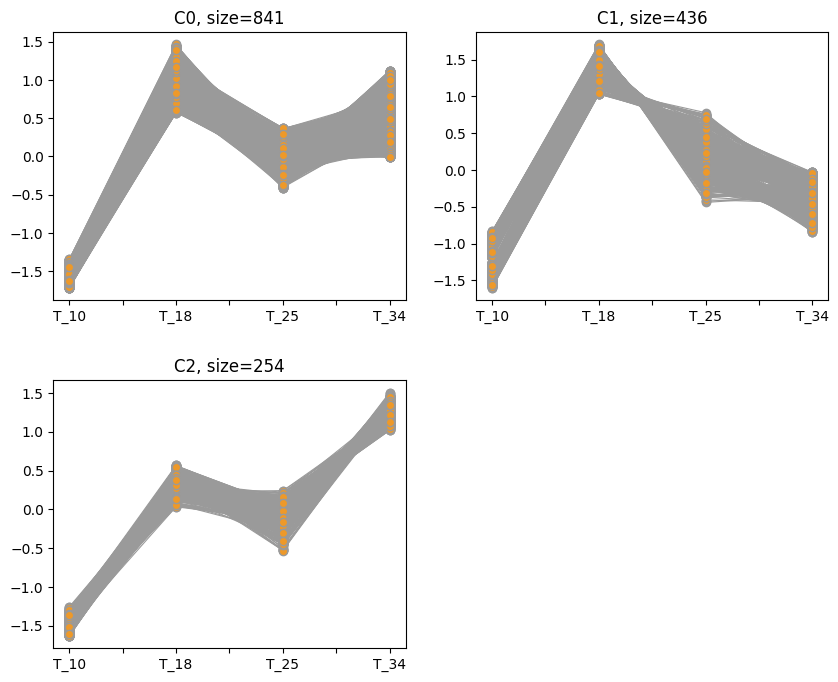

In [16]:
VI.plotClusters(
    plot_cluster_data_TCZ, clusters_TCZ,
    outfile='paper_figures/cluster_plot_TCZ.png',
    figsize=(10, 8),
    )